In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import preprocessing


## Expired Loans
first analyze loans that have been completed up to Oct 2017

In [2]:
df1 = pd.read_excel('2007_2011.xlsx',sheetname='Sheet1')
df2 = pd.read_excel('2012_2013.xlsx',sheetname='Sheet1')
df3 = pd.read_excel('2014.xlsx',sheetname='Sheet1')
df4 = pd.read_excel('2014.xlsx',sheetname='Sheet1')
df5 = pd.read_excel('2015.xlsx',sheetname='Sheet1')
df6 = pd.read_excel('2016_Q1.xlsx',sheetname='Sheet1')
df7 = pd.read_excel('2016_Q2.xlsx',sheetname='Sheet1')
df8 = pd.read_excel('2016_Q3.xlsx',sheetname='Sheet1')
df9 = pd.read_excel('2016_Q4.xlsx',sheetname='Sheet1')
df10 = pd.read_excel('2017_Q1.xlsx',sheetname='Sheet1')
df11 = pd.read_excel('2017_Q2.xlsx',sheetname='Sheet1')

In [3]:
#df = pd.concat([df1,df2,df3],join='inner')
date_before_36 = datetime.date(2014,10,1)
date_before_60 = datetime.date(2012,10,1)
#df2 = df2[((df2.term.str.contains('60')) & (df2.issue_d < date_before_60)) | (df2.term.str.contains('36'))]
#df3 = df3[(df3.term.str.contains('36')) & (df3.issue_d < date_before_36)]
data = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11],join='inner')
data = data[['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','application_type']]
data.shape

(1759709, 27)

In [4]:
data.dropna(subset=['annual_inc','grade','loan_status','issue_d','last_pymnt_d','loan_amnt'],
             inplace=True)
data.shape

(1758140, 27)

## For each grade, check default proportion

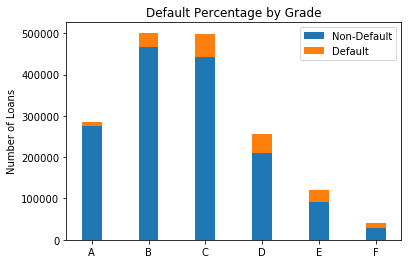

In [5]:
defal = []
nondefal = []
N = 6
for g in ['A','B','C','D','E','F']:
    data_temp = data[data.grade.str.contains(g)]
    Curr = np.sum(data_temp.loan_status.str.contains('Current'))
    Fp = np.sum(data_temp.loan_status.str.contains('Fully Paid'))
    CO = np.sum(data_temp.loan_status.str.contains('Charged Off'))
    Late = np.sum(data_temp.loan_status.str.contains('Late'))
    Default = np.sum(data_temp.loan_status.str.contains('Default'))
    defal.append(Default+CO)
    nondefal.append(Fp+Curr)
    
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, nondefal, width)
p2 = plt.bar(ind, defal, width,
             bottom=nondefal)

plt.ylabel('Number of Loans')
plt.title('Default Percentage by Grade')
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'F'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Non-Default', 'Default'))

plt.show()

## The Clustering Method
Now we use the data starting from 2010 to see the basic properties of current loans.

In [6]:
date_since_2009 = datetime.date(2010,1,1)
df1 = df1[df1.issue_d > date_since_2009]

data = pd.concat([df1,df2,df3,df4,df5,df6,df7],join='inner')
data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','application_type',
             'revol_bal','revol_util']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                          'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                          'grade','last_fico_range_high','last_fico_range_low','installment',
                         'funded_amnt','dti','funded_amnt_inv','revol_bal']
            ,inplace=True)


In [7]:
# create labels for the dataset
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default') | 
                data.loan_status.str.contains('Late'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)


# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X = data.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X = np.concatenate((X,temp.as_matrix()),axis=1)
y = data.label.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
print(X_train.shape)
print(X_test.shape)

(941344, 62)
(403434, 62)


In [12]:
n_clusters = 5
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)
kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(X_train_minmax)
#agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(X_train_minmax)
#dbscan = DBSCAN().fit(X_train_minmax)
label_train = kmeans.predict(X_train_minmax)
label_test = kmeans.predict(X_test_minmax)
#label_train = agglo.predict(X_train_minmax)
#label_test = agglo.predict(X_test_minmax)

In [13]:
for clus in range(n_clusters):
    print(np.sum(label_train == clus))

190696
239517
189487
90442
231202


In [14]:
for clus in range(n_clusters):
    X_clus_train = X_train_minmax[label_train == clus,:]
    X_clus_test = X_test_minmax[label_test == clus,:]
    y_clus_train = y_train[label_train == clus]
    y_clus_test = y_test[label_test == clus]

    rf_Entro = RandomForestClassifier(criterion='entropy',random_state=0,max_depth=10)
    rf_Entro.fit(X_clus_train,y_clus_train)
    y_pred = rf_Entro.predict(X_clus_test)
    #print('accuracy: ',accuracy_score(y_clus_test,y_pred))
    target_names = ['Non-Defaulted Loan','Defaulted Loan']
    print(classification_report(y_clus_test,y_pred,target_names=target_names,digits=4))
    print('AUC: ',roc_auc_score(y_clus_test,y_pred))
    print('')

                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9350    0.9548    0.9448     69697
    Defaulted Loan     0.7055    0.6201    0.6600     12172

       avg / total     0.9009    0.9050    0.9025     81869

AUC:  0.78745087575

                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9470    0.9619    0.9544     89372
    Defaulted Loan     0.7085    0.6323    0.6683     13093

       avg / total     0.9165    0.9198    0.9178    102465

AUC:  0.7971061225

                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9412    0.9471    0.9441     66399
    Defaulted Loan     0.7627    0.7420    0.7522     15223

       avg / total     0.9079    0.9088    0.9083     81622

AUC:  0.844515922093

                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9424    0.9199    0.9310     28936
    Defaulted Loan     0.7724    0.8287    0.7996      9490

       avg / total     0.9

## Analyze each cluster

In [11]:
for clus in range(n_clusters):
    X_test_clus = X_test[label_test == clus,:]
    print('ClusID:',clus,' Interest Rate:', np.mean(X_test_clus[:,2]),np.std())
    print('ClusID')
    print('DTI:', np.mean(X_test_clus[:,5]), 'Loan amount:',np.mean(X_test_clus[:,0]))
    print('FICO:',np.mean(X_test_clus[:,9]))
    print('')

ClusID: 0  Interest Rate: 0.133902129001
DTI: 18.1281262912 Loan amount: 13350.1113466
FICO: 672.539722573

ClusID: 1  Interest Rate: 0.158327055618
DTI: 19.4184320848 Loan amount: 20899.900594
FICO: 680.189939129

ClusID: 2  Interest Rate: 0.118941535485
DTI: 17.4616104458 Loan amount: 10339.0447675
FICO: 684.388752332

ClusID: 3  Interest Rate: 0.118005204927
DTI: 17.8014089339 Loan amount: 14295.1755699
FICO: 692.938936219

ClusID: 4  Interest Rate: 0.147282748971
DTI: 19.482385519 Loan amount: 14797.6831964
FICO: 668.718258142

ClusID: 5  Interest Rate: 0.107175284598
DTI: 17.5452185456 Loan amount: 13711.0902854
FICO: 693.243862034

